In [1]:
import scipy.optimize
import numpy as np
import pandas as pd

import os
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.pylabtools import figsize
figsize(12, 10)
sbn.set_context("paper", font_scale=1)
sbn.set_style("whitegrid")


from NOAAStations import TidalStation
from DeviceModels import Turbine, calculate_power
from Calculator import maintenance, operation

In [ ]:
def harmonicConstituentModel(time, *hm):
    assert len(hm) % 3 == 0
    velocity = 0 
    for i in range(len(hm)//3):
        velocity += hm[3*i]*np.cos((hm[3*i+1] * time + hm[3*i+2])*np.pi/180.)
    return velocity

def calculate_Installation(installations):
    return sum([i.capEx for i in installations])

def calculate_ops(ops, time):
    return(sum([o.annualCost*time for o in ops]))

def richardsCurve(Velocity,B,M,g):
    return 1200*(1+.1835*np.exp(-1*B*(Velocity-M)))**(-1/g)

def interpolate(value, from_a, from_b, to_a, to_b):
    return to_a +((to_a-to_b)/(from_a-from_b))*(value - from_a)        

def LevelizedCostofElectricity(HM,
                               number_of_turbines,
                               lifetime, 
                               K, Q, B, M, g,
                               emergency_maintentance,
                               installation,
                               operations,
                               filename = None,
                               power_array = None,
                               num = 500):
    
    '''
    This function will calculated the levelized cost of electricity given the parameters for maintenance, power generation, installation
    and lifetime
    station_id will determine the location due to the necessity to use harmonic constituents for the calculations
    grid_location is where the connections will be made
    cap_ex are the capital expenditures for the cost of the turbine and fixtures
    this function was written with a sensitivity analysis in mind
    '''
    
    MCT = Turbine(K, Q, B, M, g)
        
    if power_array is None:
        power_array , time_array = calculate_power(HM, 
                                                     MCT, 
                                                     0, 
                                                     0, 
                                                     lifetime*24*3600*365.25, 
                                                     ) # everything else is in years, need to convert to seconds for int
        time_array = time_array/(24.*3600.*365.25)
    else: 
        time_array = np.linspace(0, lifetime, len(power_array))
    ###
    # The following code is used to run the monte carlo simulation with feedback to the power generation functions
    # where the downtime requires the turbine to no longer generate an output
    ###

    power_array *= .95 #to account for voltage drop across cable
    maintenance_costs = np.zeros(num)
    power_losses = np.zeros_like(maintenance_costs)
    #time to run the simulation
    
    for i in range(num):            
        end_loop = False
        time_tracker = 0.
        power_loss = 0.
        maintenance_cost = 0.
        
        for turbine in range(number_of_turbines):
            while not end_loop:
                maintenance_event, uptime = maintenance.monteCarlo(emergency_maintentance)
                end_time = time_tracker + uptime
                maintenance_cost += maintenance_event.event_cost
                time_tracker += uptime + maintenance_event.downtime.total_seconds()/(24*3600*365.25)
                if end_time >= lifetime or time_tracker >= lifetime:
                    break
                start_index = np.searchsorted(time_array, time_tracker)
                end_index = np.searchsorted(time_array, end_time)
                energy_2 = interpolate(time_tracker, time_array[start_index-1], time_array[start_index], 
                                       power_array[start_index-1], power_array[start_index])
                energy_1 = interpolate(end_time, time_array[end_index-1], time_array[end_index], 
                                       power_array[end_index-1], power_array[end_index])
                power_loss += energy_2 - energy_1

        power_losses[i] = power_loss
        maintenance_costs[i] = maintenance_cost

    installation_cost = calculate_Installation(installation)
    planned_maintenance = .05 * installation_cost
    ops_cost = calculate_ops(operations, lifetime)
    # Process the final costs and return the levelized cost
    total_cost = np.mean(maintenance_costs) + installation_cost + ops_cost + planned_maintenance
    total_power = (power_array[-1]*number_of_turbines - np.mean(power_losses))/3600 #to kWhr!!
    with open('filename', 'w') as f:

    print('Ideal power output = {} MWhr '.format(power_array[-1]/(1000*3600)))
    print('Estimated total power loss - {} MJ, sigma = {}'.format(np.mean(power_losses)/1000, np.std(power_losses)/1000))
    print('Estimated total maintenance cost - $ {}, sigma = $ {}'.format(np.mean(maintenance_costs), np.std(maintenance_costs)))
    print('Estimated installation cost - $ {}'.format(installation_cost))
    print('Estimated operations cost - $ {}'.format(ops_cost))
    return total_cost/total_power, power_array

In [ ]:
Maintenance_Rate = namedtuple('Parameter', 'partname minimal_rate midlevel_rate severe_rate minimal_cost midlevel_cost severe_cost number labor')
CapitalInstallation = namedtuple('Parameter', 'name costPerDay timePerTurbine time numberOfTurbines scalePerTurbine')

lifetime = 20.
LCOE = []
number_of_turbines = 1
emergency_maintenance = [
    Maintenance_Rate('Blade', 0.042, 0.0273, 0.00007, 1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.),
    Maintenance_Rate('Others', 0.03, 0.0299, 0.00006, 1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.),
    Maintenance_Rate('Gear Box',0.2125, 0.0325, 0.0005, 1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.),
    Maintenance_Rate('Electricity Generator', 0.065, 0.0545, 0.0065, 1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.),
    Maintenance_Rate('Shaft', 0.002, 0.007, .001, 1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.),
    Maintenance_Rate('Brake', 0.0153, 0.0325, 0.0025,1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.),
    Maintenance_Rate('Cable', 0.225, 0.09247, 0.000002,1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.),
    Maintenance_Rate('Control system', 0.1, 0.1, 0.0001,1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.)
]


emergency_events = [maintenance.EmergencyMaintenance(
            e.minimal_rate, 
            e.midlevel_rate, 
            e.severe_rate,
            e.minimal_cost, 
            e.midlevel_cost, 
            e.severe_cost,
            number = e.number, 
            labor = e.labor, 
            partname = e.partname)
            for e in emergency_maintenance]

ops = [
    operation.OperationsCrew('Site Manager', 1, 114750),
    operation.OperationsCrew('Admin Asst', 2, 94500),
    operation.OperationsCrew('Sr. Tech', 3, 126360/3),
    operation.OperationsCrew('Jr. Tech', 6, 219024/6),
    operation.OperationsCrew('Lease', 1, 839*number_of_turbines/3)
]


In [13]:
max_average = 0 
for pkl_file in os.listdir(os.path.join('currentData')):
    if not pkl_file.startswith('COD'): continue
    station_id = pkl_file.split('.')[0]
    currents = pd.read_pickle(os.path.join('currentData', pkl_file))
    currents.dropna()
    for column in currents:
        try:
            if column.endswith('.s'): 
                average = pd.to_numeric(currents[column]).mean()
            else: 
                continue
        except TypeError:
            failures += 1
            print('uh oh')
            continue
        if float(average) > float(max_average):
            max_average = average
            location = column


    Capital_Installations = [
    CapitalInstallation('Pile Installation, Mobilize Vessel', 111000., 'n/a', 4, number_of_turbines, False),
    CapitalInstallation('Pile Installation, Transport', 167000., 'n/a', 2, number_of_turbines, False),
    CapitalInstallation('Pile Installation, Drive Piles', 164000., .3, 'n/a', number_of_turbines, True),
    CapitalInstallation('Pile Installation, transport home', 167000., 'n/a', 2, number_of_turbines, False),
    CapitalInstallation('Pile Installation, Demobilize', 110000., 'n/a', 3, number_of_turbines, False),
    CapitalInstallation('Gunderboom Sound Barrier', 4500000., 'n/a', 1, number_of_turbines, False),
    CapitalInstallation('Frame for Barrier',50000., 'n/a', 1, number_of_turbines, False),
    CapitalInstallation('Mob/Demob Sound Barrier', 70000., 'n/a', 1, number_of_turbines, False),
    CapitalInstallation('Cable transport to site',45000., 'n/a', 1, number_of_turbines, False),
    CapitalInstallation('Cables install to device',75000., .5, 'n/a', number_of_turbines, True),
    CapitalInstallation('Cable to pile',75000., .5, 'n/a', number_of_turbines, True),
    CapitalInstallation('Cable Splicing',75000., .5, 'n/a', number_of_turbines, True),
    CapitalInstallation('Cable Fairleading',75000., 'n/a', 5, number_of_turbines, False),
    CapitalInstallation('Cable through HDD', 75000., 'n/a', 2, number_of_turbines, False),
    CapitalInstallation('Cable Burial', 75000., 'n/a', 4, number_of_turbines, False),
    CapitalInstallation('Cable Testing and Commissioning',63000., 'n/a', 4, number_of_turbines, False),
    CapitalInstallation('Cable Transport Home', 45000., 'n/a', 1, number_of_turbines, False),
    CapitalInstallation('Cable - Demobilization', 46000., 'n/a', 2, number_of_turbines, False),
    CapitalInstallation('Device Installation, Mobilize Vessel', 74000., 'n/a', 4, number_of_turbines, False),
    CapitalInstallation('Device Installation, Transport to site', 79000., 'n/a', 1, number_of_turbines, False),
    CapitalInstallation('Device Installation, install',  106000., .5, 'n/a', number_of_turbines, True),
    CapitalInstallation('Device Installation, Secure Cables', 106000., .5, 'n/a', number_of_turbines, True),
    CapitalInstallation('Device Installation, Fairleading Cables',  106000., 'n/a', 2, number_of_turbines, False),
    CapitalInstallation('Device Installation, Transport Home', 87000., 'n/a', 1, number_of_turbines, False),
    CapitalInstallation('FERC Filing Fee', 91000., 'n/a', 1, number_of_turbines, False),
    CapitalInstallation('Device', 3000000., 1, 'n/a', number_of_turbines, True)]

    installations = [installation.CapitalInstallation(i.name, 
                                                      i.time, 
                                                      i.timePerTurbine, 
                                                      i.costPerDay, 
                                                      i.numberOfTurbines, 
                                                      i.scalePerTurbine)
                                                      for i in Capital_Installations ]
    
    station_id = location.split('.')[0]
    station_data = os.path.join('currentData', '{}.pkl'.format(station_id))

    currents = pd.read_pickle(station_data)
    currents.dropna()
    bin_number = location.split('.')[1]

    currents['{}.{}.s'.format(station_id, bin_number)] = pd.to_numeric(currents['{}.{}.s'.format(station_id, bin_number)])
    currents['{}.{}.d'.format(station_id, bin_number)] = pd.to_numeric(currents['{}.{}.d'.format(station_id, bin_number)])
    speedAndDirection = pd.DataFrame(currents['{}.{}.s'.format(station_id, bin_number)].values/100.*np.cos(currents['{}.{}.d'.format(station_id, bin_number)].values*np.pi/180.), 
                                     index=currents.index)

    
    Bournedale = TidalStation(8447191)
    height_constituents = Bournedale.constituents

    def set_up_least_squares(constituents, **height_constituents):
        hm = {key: float(dicts['Speed']) for key, dicts in height_constituents.items()}
        def harmonicConstituentModel(time, *amp_and_phase):
            assert len(amp_and_phase) // 2 == len(height_constituents.keys())
            assert len(amp_and_phase) % 2 == 0
            velocity = 0 
            for i, constituent in enumerate(constituents):
                velocity += amp_and_phase[2*i]*np.cos((hm[constituent] * time + amp_and_phase[2*i+1])*np.pi/180.)
            return velocity    
        return harmonicConstituentModel

    velocities = speedAndDirection.as_matrix()
    time = np.arange(0, len(velocities))*6/60
    data = np.column_stack((time, velocities[:,0]))
    data = data[~np.isnan(data).any(axis=1)]
    upper_bounds = []
    starting_guess = []
    constituents = []
    for keys, dicts in height_constituents.items():
        starting_guess.append(float(dicts['Amplitude']))
        upper_bounds.append(np.inf)
        if float(dicts['Phase'])+180 < 360: starting_guess.append(float(dicts['Phase']) + 180)
        else: starting_guess.append(float(dicts['Phase']) - 180)
        upper_bounds.append(360)
        constituents.append(keys)

    lower_bounds = [0]*len(upper_bounds)    
    param_bounds = (lower_bounds, upper_bounds)
    starting_guess = tuple(starting_guess)

    optimized_parameters, covariance = scipy.optimize.curve_fit(set_up_least_squares(constituents, **height_constituents), 
                                                             xdata = data[:,0], 
                                                             ydata = data[:,1],
                                                             bounds = param_bounds,
                                                             p0 = starting_guess)
    
    with open('HM-{}-{}.txt'.format(station_id, bin_number),'w') as myFile:
        for i, constituent in enumerate(constituents):
            myFile.write('{},{},{}\n'.format(optimized_parameters[2*i],height_constituents[constituent]['Speed'], optimized_parameters[2*i+1]))

    HM = []
    with open('HM-{}-{}.txt'.format(station_id, 38),'r') as myFile:
        for i, line in enumerate(myFile):
            amplitude, speed, phase  = line.split(',')
            HM.append(float(amplitude))
            HM.append(float(speed))
            HM.append(float(phase))           
    HM_tuple = tuple(HM)        
    result, power_array = LevelizedCostofElectricity(HM_tuple, number_of_turbines, lifetime, 1200., 0.1835, 3.55361367,  2.30706792,  1.05659521,
                           emergency_events, installations, ops)

    print('LCOE for {} turbine(s) was {}'.format(station_id, LCOE[-1]))
    print('-'*80)            
    


Found max speed of 1.9587582958380205 in COI0301.25.s


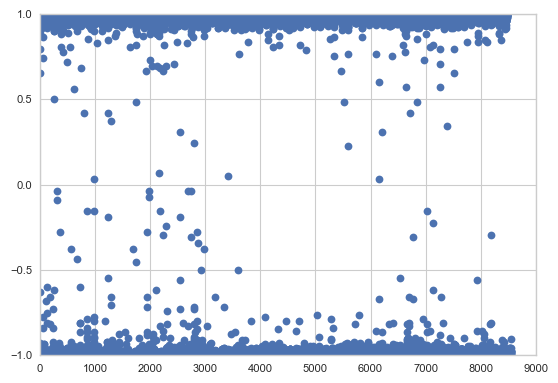

In [16]:


        
print(optimized_parameters)


[  5.73254922e+00   1.40936842e+02   1.21216727e-01   2.62315022e+02
   8.20705689e-03   2.36673756e+02   2.42245676e-02   2.91409618e+02
   2.44350358e-02   2.66552648e+02   2.54602967e-02   1.68298109e+02
   9.66104673e-01   2.52330512e+01   2.47480929e-02   5.17016699e+01
   6.20672628e-01   2.63680280e+02   3.10810743e-01   2.84565983e+02
   5.56495854e-38   3.58950336e+02   1.75256041e-02   1.79823342e+02
   2.75653693e-02   9.51747159e+01   1.96219225e+00   1.64535074e+02
   2.73391263e-02   2.21999650e+02   1.00158061e-01   1.64702987e+02
   2.38302658e+00   2.93805773e+02   2.69039862e-02   1.35168633e+02
   1.16828178e+00   3.23684683e+02   6.55287237e-35   3.03935145e+02
   1.01606518e+00   3.60000000e+02   1.51409809e-02   1.24320515e+02
   8.58885734e-01   3.59996195e+02   6.59855501e-03   3.60000000e+02
   3.40527130e-35   3.03108592e+02   3.39890661e-02   1.82989105e+02
   1.05730986e+01   3.05867240e+02   4.12817931e-01   7.16388195e+01
   1.50562429e-02   1.06188856e+02

['T2', 'O1', 'S4', 'M8', 'J1', 'M4', 'LAM2', 'M3', 'N2', 'M6', '2MK3', '2Q1', 'MF', 'S1', 'MM', '2N2', 'M2', 'S6', 'K1', 'Q1', 'P1', 'M1', 'K2', 'RHO', 'MU2', 'MS4', 'S2', 'NU2', '2SM2', 'MN4', 'MK3', 'SA', 'SSA', 'L2', 'R2', 'OO1', 'MSF']


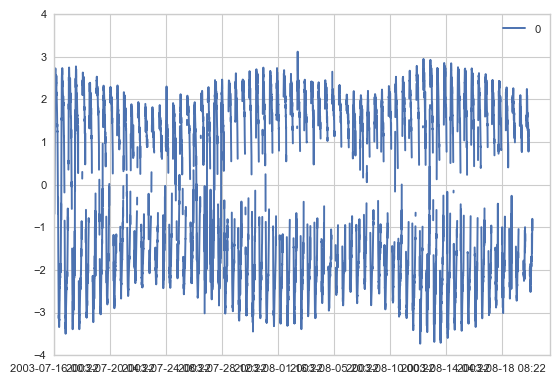

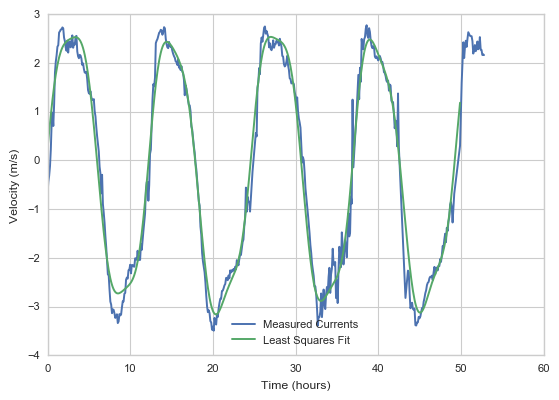

In [20]:
def harmonicConstituentModel(time, *hm):
    assert len(hm) % 3 == 0
    velocity = 0 
    for i in range(len(hm)//3):
        velocity += hm[3*i]*np.cos((hm[3*i+1] * time + hm[3*i+2])*np.pi/180.)
    return velocity


plt.figure()
speedAndDirection.plot()
plt.show()

velocities = speedAndDirection.as_matrix()

time = np.arange(0, len(velocities))*6/60
data = np.column_stack((time, velocities[:,0]))
data = data[~np.isnan(data).any(axis=1)]

t = np.arange(0, 50, .1)
optimized_parameters = []
with open('HM-{}-{}.txt'.format(station_id, 38),'r') as myFile:
    for i, line in enumerate(myFile):
        amplitude, speed, phase  = line.split(',')
        optimized_parameters.append(float(amplitude))
        optimized_parameters.append(float(speed))
        optimized_parameters.append(float(phase))

graph2 = harmonicConstituentModel(t, *optimized_parameters)
plt.plot(data[:500,0], data[:500,1], label='Measured Currents')
plt.plot(t, graph2, label='Least Squares Fit')
plt.legend(loc='best')
plt.xlabel('Time (hours)')
plt.ylabel('Velocity (m/s)')
plt.show()
